<h1 style='text-align: center'>Análise e Previsão de Alugeis no Brasil</h1>

<h2>Importações</h2>

In [1]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

<h2>Carregando Base de Dados</h2>

In [2]:
# Carregando base de dados usando Spark
base = './dados/houses_to_rent_v2.csv'
df = spark.read.csv(base, header=True, inferSchema=False)

<h2>Tratamento dos Dados</h2>

<h3>Conhecendo a Base de Dados</h3>

Antes de iniciarmos as transformações, explorações e análises, é essencial que nos familiarizemos adequadamente com a base de dados. Isso proporcionará uma compreensão mais sólida do contexto e dos elementos-chave, permitindo-nos realizar as etapas subsequentes de maneira mais informada e eficaz.

#### Descrição dos dados do dataset:

1. **city**: Cidade onde o imóvel está localizado
2. **area**: Area do imovel
3. **rooms**: Número de quartos
4. **bathroom**: Número de banheiros
5. **parking spaces**: Número de vagas
6. **floor**: Andar
7. **animal**: Imovel aceita animais ou não
8. **furniture**: Imovel está mobiliado ou não
9. **hoa**: Valor do condominio
10. **rent amount**: Valor do aluguel
11. **property tax**: IPTU
12. **fire insurance**: Seguro incendio
13. **total**: Valor total

In [3]:
# visualizando as primeiras linhas
df.toPandas().head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [4]:
# visualizando as últimas linhas
df.toPandas().tail()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020
10691,São Paulo,80,2,1,0,-,acept,not furnished,0,1400,165,22,1587


In [5]:
def dimensao(dados):
    '''Retorna as dimensões do dataframe.'''
    print('Linhas:', dados.count())
    print('Colunas:', len(dados.columns))

In [6]:
# Dimensão do dataframe
dimensao(df)

Linhas: 10692
Colunas: 13


In [7]:
# Informações dos dados do dataset
df.printSchema()

root
 |-- city: string (nullable = true)
 |-- area: string (nullable = true)
 |-- rooms: string (nullable = true)
 |-- bathroom: string (nullable = true)
 |-- parking spaces: string (nullable = true)
 |-- floor: string (nullable = true)
 |-- animal: string (nullable = true)
 |-- furniture: string (nullable = true)
 |-- hoa (R$): string (nullable = true)
 |-- rent amount (R$): string (nullable = true)
 |-- property tax (R$): string (nullable = true)
 |-- fire insurance (R$): string (nullable = true)
 |-- total (R$): string (nullable = true)



In [8]:
# Verificando valores faltantes ou nulos
for coluna in df.columns:
    print(coluna, df.filter(col(coluna).isNull()).count())

city 0
area 0
rooms 0
bathroom 0
parking spaces 0
floor 0
animal 0
furniture 0
hoa (R$) 0
rent amount (R$) 0
property tax (R$) 0
fire insurance (R$) 0
total (R$) 0


In [9]:
# Verificando quantidade de valores únicos de cada coluna
for coluna in df.columns:
    valores_unicos = df.select(countDistinct(col(coluna)).alias('count')).collect()[0]['count']
    print('coluna:',coluna,'-',valores_unicos)

coluna: city - 5
coluna: area - 517
coluna: rooms - 11
coluna: bathroom - 10
coluna: parking spaces - 11
coluna: floor - 35
coluna: animal - 2
coluna: furniture - 2
coluna: hoa (R$) - 1679
coluna: rent amount (R$) - 1195
coluna: property tax (R$) - 1243
coluna: fire insurance (R$) - 216
coluna: total (R$) - 5751


<h3>Transformando a Base de Dados</h3>

Após uma análise inicial da base de dados, estamos prontos para iniciar o processo de tradução dos títulos das colunas, ajuste dos valores das variáveis, remoção de dados duplicados e modificação dos tipos de dados, incluindo a conversão entre strings, inteiros e floats conforme necessário.

In [10]:
# Alterando título das colunas do dataset
novo_titulo = [
    'cidade', 'area', 'quartos', 'banheiros', 'vagas', 'andar', 'animais',
    'mobilia', 'condominio', 'aluguel', 'iptu', 'seguro', 'total'
]
for indice, coluna in enumerate(df.columns):
    df = df.withColumnRenamed(coluna , novo_titulo[indice])

In [11]:
# Alterando atributo da coluna 'animal'
# not acept iremos alterar para 0
# acept iremos alterar para 1
df = df.withColumn('animais', when(col('animais') == 'not acept',0).otherwise(col('animais')))\
    .withColumn('animais', when(col('animais') == 'acept',1).otherwise(col('animais')))

# Alterando atributo da coluna 'mobilia'
# not furnished iremos alterar para 0
# furnished iremos alterar para 1
df = df.withColumn('mobilia', when(col('mobilia') == 'not furnished',0).otherwise(col('mobilia')))\
    .withColumn('mobilia', when(col('mobilia') == 'furnished',1).otherwise(col('mobilia')))

# Alterando valoe '-' para 0 na coluna andar
df = df.withColumn('andar', when(col('andar') == '-', 0).otherwise(col('andar')))

In [12]:
def converte_dados(dados):
    '''Converte o tipo dos dados das colunas numéricas.'''
    for coluna in dados.columns[1:8]:
        dados = dados.withColumn(coluna, col(coluna).cast('int'))

    for coluna in dados.columns[8:]:
        dados = dados.withColumn(coluna, col(coluna).cast('float'))
    
    return dados

In [13]:
# Convertendo as colunas string em int e float
df = converte_dados(df)

In [14]:
# Verificando alteração
df.printSchema()

root
 |-- cidade: string (nullable = true)
 |-- area: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- vagas: integer (nullable = true)
 |-- andar: integer (nullable = true)
 |-- animais: integer (nullable = true)
 |-- mobilia: integer (nullable = true)
 |-- condominio: float (nullable = true)
 |-- aluguel: float (nullable = true)
 |-- iptu: float (nullable = true)
 |-- seguro: float (nullable = true)
 |-- total: float (nullable = true)



In [15]:
# Removendo registros duplicados
df = df.dropDuplicates()

In [16]:
# Visualizando base transformada
df.show(5)

+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
|        cidade|area|quartos|banheiros|vagas|andar|animais|mobilia|condominio|aluguel| iptu|seguro| total|
+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
|     São Paulo|  30|      1|        1|    0|    1|      1|      0|     460.0| 1600.0|  0.0|  21.0|2081.0|
|Rio de Janeiro| 130|      3|        2|    1|    7|      1|      0|    1660.0| 1700.0|475.0|  22.0|3857.0|
|     São Paulo|  96|      3|        2|    2|   17|      1|      0|     804.0| 3200.0|250.0|  41.0|4295.0|
|Rio de Janeiro| 107|      3|        2|    0|    7|      1|      1|    1460.0| 3200.0|270.0|  42.0|4972.0|
|Rio de Janeiro| 105|      3|        2|    0|    1|      1|      0|     740.0| 2200.0|  9.0|  29.0|2978.0|
+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
only showing top 5 rows



In [17]:
# Dimensões do dataframe
dimensao(df)

Linhas: 10334
Colunas: 13


<h3>Tratando Outliers</h3>

A fim de avançar nas análises, é imperativo assegurar a consistência dos dados. Para alcançar esse objetivo, faremos uma análise para identificar a presença de outliers e, se necessário, implementaremos os devidos procedimentos de tratamento.

In [18]:
def estatisticas(dados):
    '''Calcula e retorna a estatística descritiva da base de dados.'''
    summary = pd.DataFrame()
    for coluna in dados.columns[1:]:
        temp_df = dados.select(coluna).summary('min', '25%', '50%', '75%', 'max').toPandas()
        summary = pd.concat([summary, temp_df], axis=1)
    summary = summary.loc[:,~summary.columns.duplicated()]
    summary.set_index('summary', inplace=True)

    return summary

In [19]:
# Estatística descritiva da base de dados
estatisticas(df)

,area,quartos,banheiros,vagas,andar,animais,mobilia,condominio,aluguel,iptu,seguro,total
summary,,,,,,,,,,,,
min,11,1,1,0,0,0,0,0.0,450.0,0.0,3.0,499.0
25%,59,2,1,1,1,1,0,180.0,1590.0,40.0,21.0,2115.0
50%,95,3,2,1,3,1,0,571.0,2750.0,130.0,37.0,3685.0
75%,190,3,3,2,8,1,0,1286.0,5000.0,389.0,70.0,6909.0
max,46335,13,10,12,301,1,1,1117000.0,45000.0,313700.0,677.0,1120000.0


Ao examinar a tabela de estatísticas descritivas do dataframe, torna-se evidente a presença de outliers, destacando-se especialmente nas variáveis área, andar, condomínio e IPTU. Será realizada uma análise abrangente de todas essas variáveis.

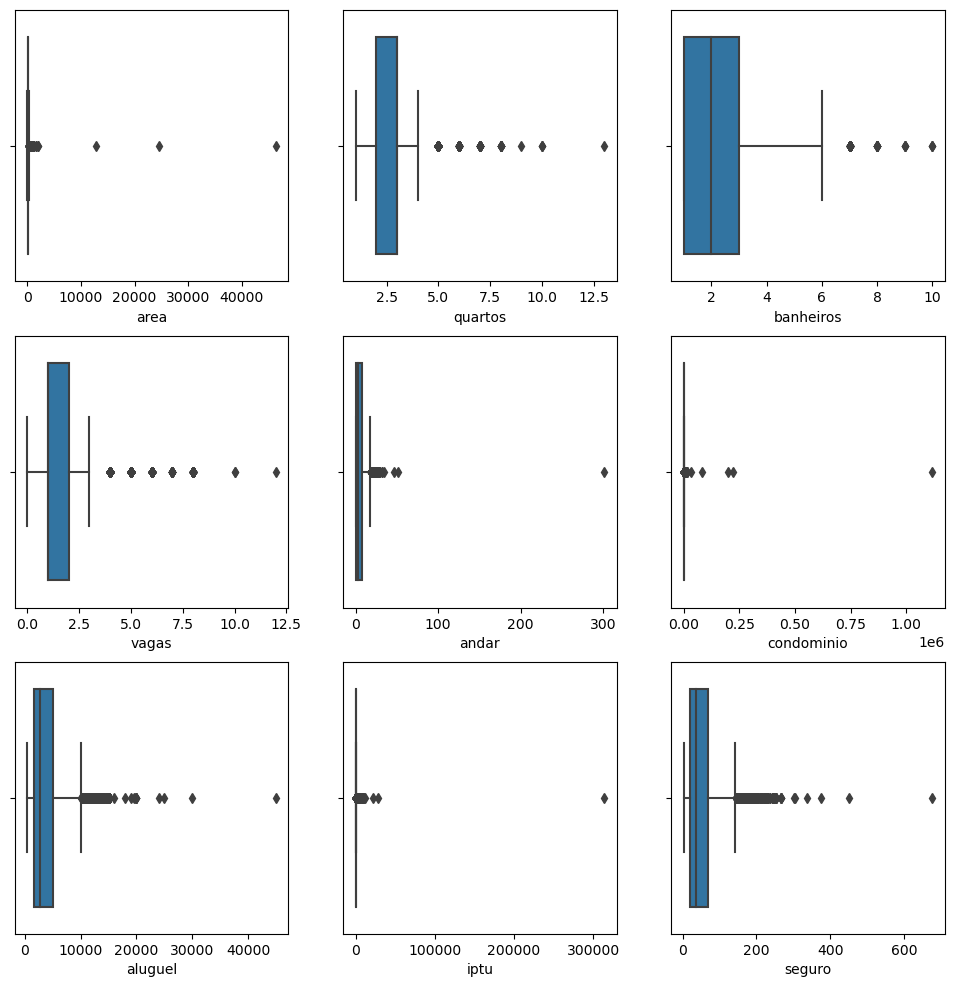

In [20]:
# Gerando gráficos boxplot para a visualização dos outliers
df_pandas = df.toPandas()

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
sns.boxplot(data=df_pandas, x='area', ax=axs[0, 0])
sns.boxplot(data=df_pandas, x='quartos', ax=axs[0, 1])
sns.boxplot(data=df_pandas, x='banheiros', ax=axs[0, 2])
sns.boxplot(data=df_pandas, x='vagas', ax=axs[1, 0])
sns.boxplot(data=df_pandas, x='andar', ax=axs[1, 1])
sns.boxplot(data=df_pandas, x='condominio', ax=axs[1, 2])
sns.boxplot(data=df_pandas, x='aluguel', ax=axs[2, 0])
sns.boxplot(data=df_pandas, x='iptu', ax=axs[2, 1])
sns.boxplot(data=df_pandas, x='seguro', ax=axs[2, 2])

plt.savefig('./img/graficos/outliers.png', format='png')
plt.show()

Ao examinar minuciosamente os gráficos boxplots, notamos a distorção provocada pelos outliers. Nesse contexto, planejamos abordar todos os valores que ultrapassam os limites superiores estabelecidos para cada coluna, visando uma correção mais precisa e robusta dos dados.

In [23]:
def upper_bound(dados, coluna):
    '''Retorna o valor o limite superior de cada coluna.'''
    quartis = dados.approxQuantile(coluna, [0.25,0.75],0.01)
    q1 = quartis[0]
    q3 = quartis[1]
    iqr = q3 - q1
    print(q3 + 1.5 * iqr)

In [28]:
# Retorna os valores dos limites superiores de cada coluna
for coluna in df.columns[1:]:
    upper_bound(df, coluna)

363.0
4.5
6.0
3.5
18.5
1.0
0.0
2800.0
10175.0
877.5
136.0
13636.0


In [29]:
# Removendo outliers apartir dos limites superiores de cada coluna
df_tratado = df.filter((col('area') <= 500) & (col('quartos') <= 5) & (col('banheiros') <= 6) & (col('vagas') <= 4)\
                      & (col('andar') <= 20) & (col('condominio') <= 2800.0) & (col('aluguel') <= 10175.0)\
                      & (col('iptu') <= 877.5) & (col('seguro') <= 136.0) & (col('total') <= 13636.0))

In [30]:
# Dimensões do dataframe
dimensao(df_tratado)

Linhas: 8308
Colunas: 13


In [31]:
# Estatística do dataframe tratado
estatisticas(df_tratado)

,area,quartos,banheiros,vagas,andar,animais,mobilia,condominio,aluguel,iptu,seguro,total
summary,,,,,,,,,,,,
min,11,1,1,0,0,0,0,0.0,450.0,0.0,3.0,499.0
25%,52,1,1,0,1,1,0,227.0,1400.0,27.0,19.0,1881.0
50%,78,2,2,1,3,1,0,530.0,2230.0,94.0,30.0,3016.0
75%,130,3,2,2,8,1,0,1000.0,3550.0,234.0,49.0,4835.0
max,500,5,6,4,20,1,1,2800.0,10140.0,876.0,136.0,13490.0


Após realizar o devido tratamento no dataframe, torna-se evidente a presença de simetria nos dados ao examinar a tabela de estatísticas descritivas. Essa abordagem refinada possibilita a obtenção de insights mais precisos sobre a distribuição e a estrutura dos dados.

As estatísticas reunem informações sobre áreas, quantidade de quartos, banheiros, vagas de estacionamento, andar, aceitação de animais, mobília, valores de condomínio, aluguel, IPTU, seguro e custo total. Destacam-se características como:

- Área mediana de 78 metros quadrados.
- Mediana de 2 quartos e 2 banheiros.
- As propriedades possuem uma mediana de 1 vaga de estacionamento.
- A maioria aceita animais, mas não é mobiliada.
- Os valores variam, com mediana de 2.230,00 para aluguel e 3.016,00 como custo total.
- O condomínio varia de 0,00 a 2.800,00.
- O custo total pode atingir até 13.490,00, englobando aluguel, condomínio, IPTU e seguro.

Essas estatísticas oferecem uma visão geral das características e custos das propriedades para aluguel, facilitando a compreensão da distribuição e das tendências do mercado imobiliário analisado.

**Salvando Dataframe tratado**

In [32]:
df_tratado.toPandas().to_csv('./dados/house_to_rent_tratado.csv', index=False)

<h2>Análise Exploratória dos Dados</h2>

In [33]:
# Carregando dataset tratado
base = './dados/house_to_rent_tratado.csv'
dados = spark.read.csv(base, header=True, inferSchema=False)

# Visualizando o dataframe
dados.show(5)

+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
|        cidade|area|quartos|banheiros|vagas|andar|animais|mobilia|condominio|aluguel| iptu|seguro| total|
+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
|     São Paulo|  30|      1|        1|    0|    1|      1|      0|     460.0| 1600.0|  0.0|  21.0|2081.0|
|Rio de Janeiro| 130|      3|        2|    1|    7|      1|      0|    1660.0| 1700.0|475.0|  22.0|3857.0|
|     São Paulo|  96|      3|        2|    2|   17|      1|      0|     804.0| 3200.0|250.0|  41.0|4295.0|
|Rio de Janeiro| 107|      3|        2|    0|    7|      1|      1|    1460.0| 3200.0|270.0|  42.0|4972.0|
|Rio de Janeiro| 105|      3|        2|    0|    1|      1|      0|     740.0| 2200.0|  9.0|  29.0|2978.0|
+--------------+----+-------+---------+-----+-----+-------+-------+----------+-------+-----+------+------+
only showing top 5 rows



In [34]:
# Dimensões do dataframe
dimensao(dados)

Linhas: 8308
Colunas: 13


In [35]:
# Transformando colunas numéricas em int e float
dados = converte_dados(dados)

<h3>Correlação Entre as Variáveis da Base de Dados</h3>

O gráfico a seguir, nos mostra a correlação entre as variáveis da base de dados. Algumas observações importantes incluem fortes correlações positivas entre o número de quartos, banheiros, vagas de estacionamento e a área total, ou seja quanto maior o número de ambientes maior será a área do imóvel. Custos como aluguel, IPTU e seguro estão altamente correlacionados. O andar do imóvel está relacionado positivamente com o valor do condomínio. Há também correlações entre aluguel e outras variáveis, indicando que propriedades maiores tendem a ter valores mais altos. A correlação não implica causalidade, sendo necessárias análises mais aprofundadas para uma compreensão completa das relações.

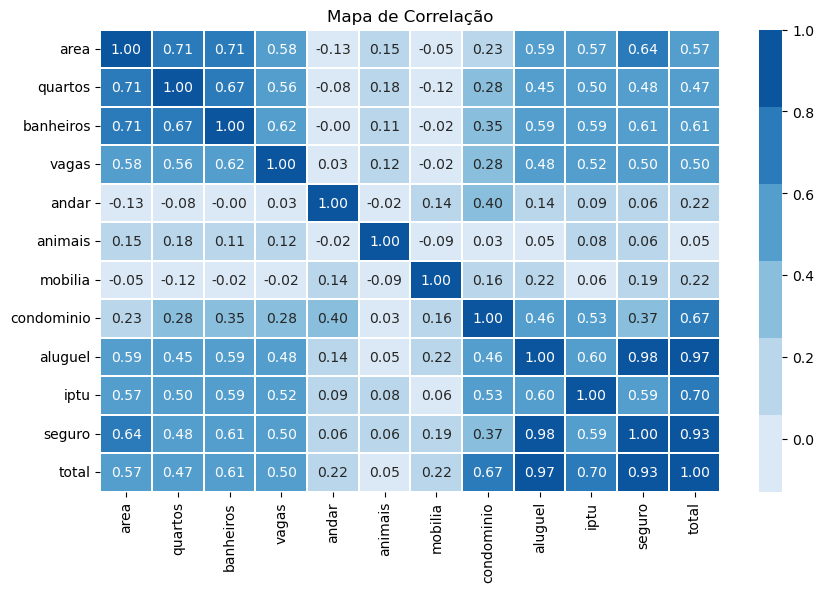

In [112]:
df = dados.toPandas().drop(df.columns[0], axis=1)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap=sns.color_palette('Blues'), linewidths=.2, annot=True, fmt='.2f')
plt.title('Mapa de Correlação')
plt.savefig('./img/graficos/correlacao.png', format='png')
plt.show()

As hipóteses a seguir serão úteis para conduzir uma análise mais detalhada dos dados, com o objetivo de investigar as interações entre as variáveis e extrair insights significativos sobre o mercado imobiliário representado pela base de dados.

<h3>1. Relação entre Área e Aluguel</h3>

Existe uma correlação positiva entre o valor do aluguel e a área do imóvel, indicando que à medida que a área do imóvel aumenta, observa-se um aumento proporcional no valor do aluguel. Este padrão sugere que há uma influência significativa do tamanho do imóvel sobre o preço de locação, destacando a importância da dimensão física na determinação do custo associado à ocupação do espaço.

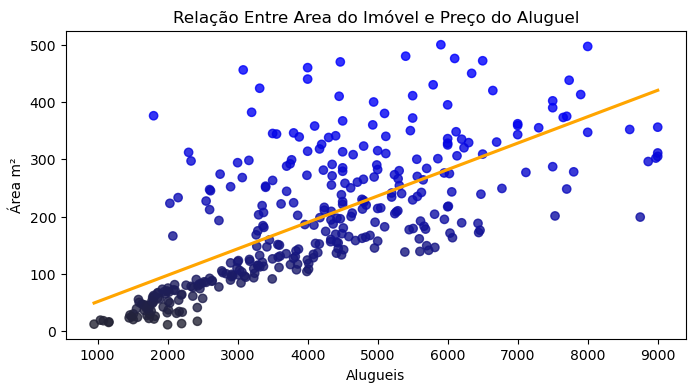

In [138]:
df = dados.select('area', 'aluguel').toPandas().groupby('area')['aluguel'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.regplot(df, x='aluguel', y='area', ci=None, fit_reg=True, color='orange',
            scatter_kws={'color': sns.color_palette('dark:b', n_colors=len(df['area']))})
plt.title('Relação Entre Area do Imóvel e Preço do Aluguel')
plt.xlabel('Alugueis')
plt.ylabel('Área m²')
plt.savefig('./img/graficos/area_aluguel.png', format='png')
plt.show()

<h3>2. Efeito da Localização Geográfica no Tamanho da Área do Imóvel</h3>

O tamanho da área dos imóveis pode variar consideravelmente com base na localização geográfica da cidade. É perceptível que Belo Horizonte se destaca ao apresentar imóveis com áreas mais amplas, seguido por São Paulo e Campinas. Por outro lado, Porto Alegre e Rio de Janeiro evidenciam as menores áreas, chegando inclusive a serem equivalentes.

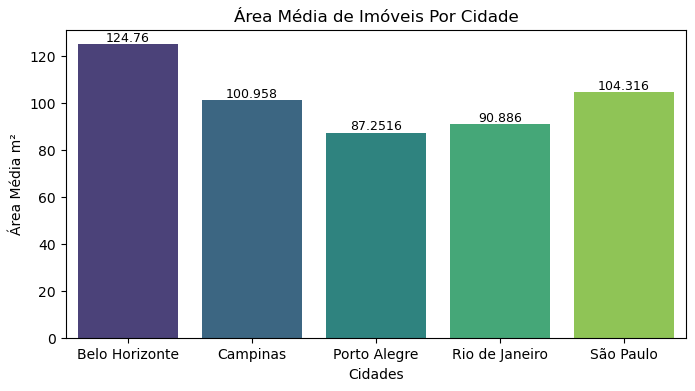

In [37]:
df = dados.select('cidade','area').toPandas().groupby('cidade')['area'].mean().reset_index()
plt.figure(figsize=(8,4))
ax = sns.barplot(df, x='cidade', y='area', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=9)
plt.title('Área Média de Imóveis Por Cidade')
plt.xlabel('Cidades')
plt.ylabel('Área Média m²')
plt.savefig('./img/graficos/area_cidade.png', format='png')
plt.show()

<h3>3. Impacto da Localização no Aluguel</h3>

As médias de aluguéis em São Paulo e Rio de Janeiro destacam-se como mais elevadas em comparação com outras cidades. Ao analisarmos o gráfico anterior, observamos uma inversão interessante: embora Belo Horizonte apresente imóveis de tamanho superior aos de São Paulo e Rio de Janeiro, a situação se inverte quando se trata do valor do aluguel. Nesse contexto, São Paulo assume a liderança, seguido pelo Rio de Janeiro. Isso sugere que, dependendo da cidade do imóvel, o aluguel será determinado conforme o mercado local.

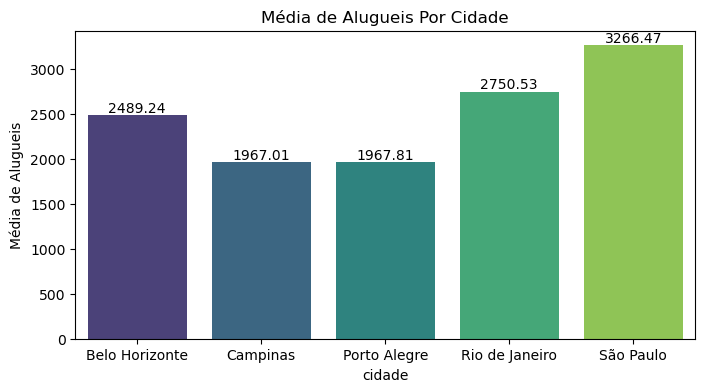

In [38]:
df = dados.select('cidade','aluguel').toPandas().groupby('cidade')['aluguel'].mean().reset_index()
plt.figure(figsize=(8,4))
ax = sns.barplot(df, x='cidade', y='aluguel', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Média de Alugueis Por Cidade')
plt.ylabel('Média de Alugueis')
plt.savefig('./img/graficos/aluguel_cidade.png', format='png')
plt.show()

<h3>4. Influência do Número de Quartos e Banheiros no Aluguel</h3>

A quantidade de quartos e banheiros exerce uma influência direta sobre o valor do aluguel. É evidente que à medida que se aumenta o número de quartos e banheiros, há uma tendência de elevação nos preços de locação, conforme visualizado no gráfico. Essa relação sugere que as características de um imóvel, especificamente o número de seus quartos e banheiros, desempenham um papel significativo na determinação do custo associado à sua locação.

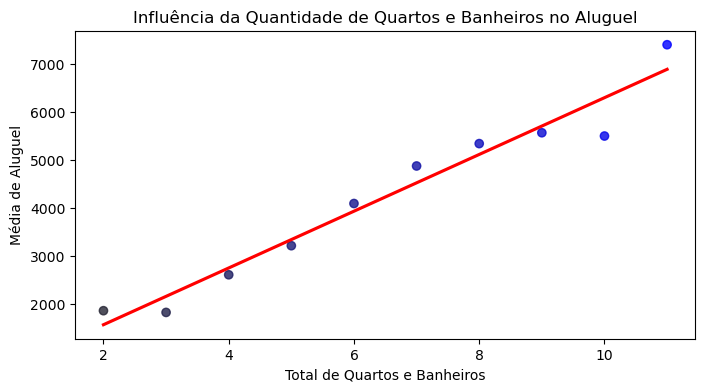

In [128]:
df = dados.select('quartos','banheiros','aluguel').withColumn('comodos', col('quartos') + col('banheiros'))\
    .select('comodos','aluguel').toPandas().groupby('comodos')['aluguel'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.regplot(df, x='comodos', y='aluguel', ci=None, fit_reg=True, color='r',
            scatter_kws={'color': sns.color_palette('dark:b', n_colors=len(df['aluguel']))})
plt.title('Influência da Quantidade de Quartos e Banheiros no Aluguel')
plt.xlabel('Total de Quartos e Banheiros')
plt.ylabel('Média de Aluguel')
plt.savefig('./img/graficos/comodos_aluguel.png', format='png')
plt.show()

<h3>5. Andar e Valor do Aluguel</h3>

A relação entre a altura do andar e o valor do aluguel é claramente perceptível nos dados apresentados no gráfico. Nota-se uma tendência evidente de aumento no valor do aluguel à medida que a altura do andar cresce. Essa relação linear sugere que imóveis localizados em andares mais elevados têm um custo de locação superior, indicando uma influência direta da elevação no preço do aluguel.

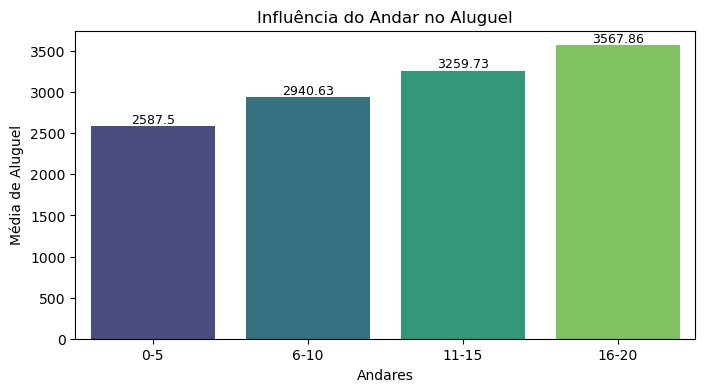

In [40]:
df = dados.select('andar','aluguel').toPandas()
bins = [0, 5, 10, 15, 20]
labels = ['0-5', '6-10', '11-15', '16-20']
df['faixa_andar'] = pd.cut(df['andar'], bins=bins, labels=labels, right=False)
df = df.groupby('faixa_andar')['aluguel'].mean().reset_index()

plt.figure(figsize=(8,4))
ax = sns.barplot(df, x='faixa_andar', y='aluguel', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=9)
plt.title('Influência do Andar no Aluguel')
plt.xlabel('Andares')
plt.ylabel('Média de Aluguel')
plt.savefig('./img/graficos/andar_aluguel.png', format='png')
plt.show()

<h3>6. Andar e Valor do Condomínio</h3>

A relação entre a altura do andar e o valor do condomínio é claramente destacada nos dados apresentados. Ao compararmos o gráfico anterior, agora focado nos custos condominiais, observa-se que imóveis com até 5 andares apresentam os valores de condomínio mais baixos. No entanto, entre imóveis com 6 a 20 andares, não há diferenças significativas nos valores de condomínio. Esta análise sugere que, a altura do andar influencia de maneira notável os custos condominiais em edifícios acima de 5 andares.

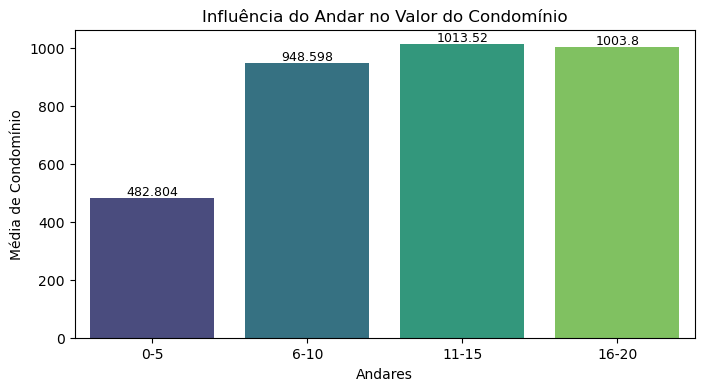

In [41]:
df = dados.select('andar','condominio').toPandas()
bins = [0, 5, 10, 15, 20]
labels = ['0-5', '6-10', '11-15', '16-20']
df['faixa_andar'] = pd.cut(df['andar'], bins=bins, labels=labels, right=False)
df = df.groupby('faixa_andar')['condominio'].mean().reset_index()

plt.figure(figsize=(8,4))
ax = sns.barplot(df, x='faixa_andar', y='condominio', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=9)
plt.title('Influência do Andar no Valor do Condomínio')
plt.xlabel('Andares')
plt.ylabel('Média de Condomínio')
plt.savefig('./img/graficos/andar_condominio.png', format='png')
plt.show()

<h3>7. Aceitação de Animais com o Valor do Aluguel e Condomínio</h3>

A presença de animais de estimação em imóveis pode influenciar positivamente o valor do aluguel e do condomínio, conforme evidenciado pelos gráficos. Apesar de não expressarem aumentos significativos, os imóveis que aceitam animais cobram um pouco mais como podemos observar. Esse padrão sugere que proprietários ou locadores podem precificar mais elevadamente imóveis que permitam a presença de animais.

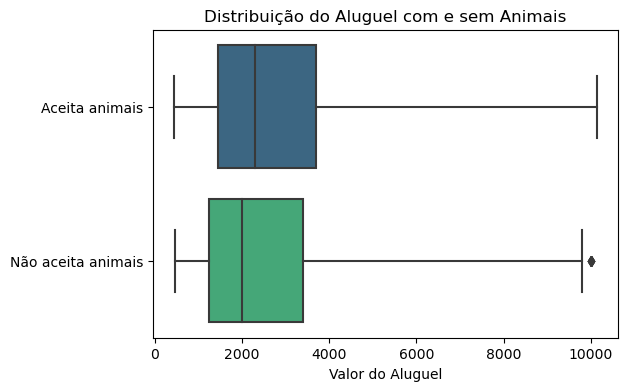

In [42]:
df = dados.select('animais','aluguel').toPandas()
df.animais = df.animais.replace([0,1],['Não aceita animais', 'Aceita animais'])
plt.figure(figsize=(6, 4))
sns.boxplot(df, x='aluguel', y='animais', palette='viridis', whis=3)
plt.title('Distribuição do Aluguel com e sem Animais')
plt.ylabel('')
plt.xlabel('Valor do Aluguel')
plt.savefig('./img/graficos/animais_aluguel.png', format='png')
plt.show()

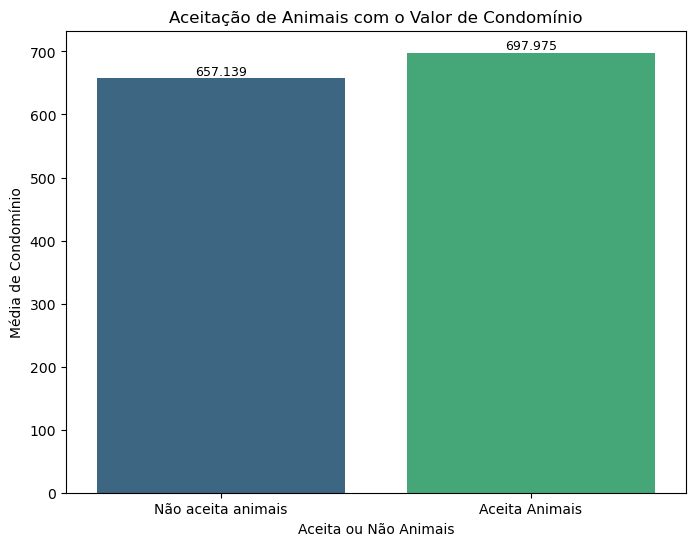

In [43]:
df = dados.select('animais','condominio').toPandas().groupby('animais')['condominio'].mean().reset_index()
df.animais = df.animais.replace([0,1],['Não aceita animais', 'Aceita Animais'])
plt.figure(figsize=(8,6))
ax = sns.barplot(df, x='animais', y='condominio', errorbar=None, palette='viridis')
ax.bar_label(ax.containers[0], fontsize=9)
plt.title('Aceitação de Animais com o Valor de Condomínio')
plt.xlabel('Aceita ou Não Animais')
plt.ylabel('Média de Condomínio')
plt.savefig('./img/graficos/animais_condominio')
plt.show()

<h3>8. Imóveis com Mobilia Influênciam no Valor do Aluguel</h3>

O gráfico apresentado evidencia que imóveis mobiliados tendem a ter um custo de aluguel superior. A análise visual dos dados revela uma clara distinção, indicando que a presença de mobília está associada a um aumento no valor do aluguel. Essa tendência sugere que a comodidade e praticidade proporcionadas por um imóvel já mobiliado são refletidas no preço, representando um fator significativo a ser considerado por locatários em busca de conveniência e conforto.

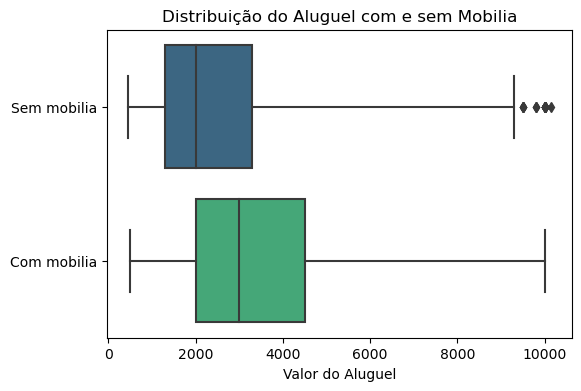

In [44]:
df = dados.select('mobilia','aluguel').toPandas()
df.mobilia = df.mobilia.replace([0,1],['Sem mobilia','Com mobilia'])
plt.figure(figsize=(6, 4))
sns.boxplot(df, x='aluguel', y='mobilia', palette='viridis', whis=3)
plt.title('Distribuição do Aluguel com e sem Mobilia')
plt.ylabel('')
plt.xlabel('Valor do Aluguel')
plt.savefig('./img/graficos/mobilia_aluguel.png', format='png')
plt.show()

<h3>9. Custo Adicional de Vagas de Estacionamento</h3>

O valor do aluguel tende a ser mais elevado para imóveis que oferecem vagas de estacionamento, conforme evidenciado no gráfico. A análise revela uma correlação positiva entre a quantidade de vagas de estacionamento disponíveis e o valor do aluguel, indicando que à medida que o número de vagas aumenta, o custo do aluguel também se eleva. Esta associação sugere que a conveniência e a disponibilidade de estacionamento exercem uma influência significativa na determinação do valor do aluguel.

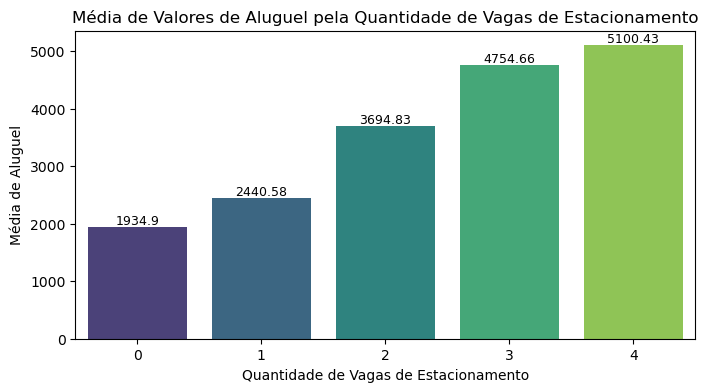

In [45]:
df = dados.select('vagas','aluguel').toPandas().groupby('vagas')['aluguel'].mean().reset_index()
plt.figure(figsize=(8,4))
ax = sns.barplot(df, x='vagas', y='aluguel', palette='viridis')
ax.bar_label(ax.containers[0], fontsize=9)
plt.title('Média de Valores de Aluguel pela Quantidade de Vagas de Estacionamento')
plt.xlabel('Quantidade de Vagas de Estacionamento')
plt.ylabel('Média de Aluguel')
plt.savefig('./img/graficos/vaga_aluguel.png', format='png')
plt.show()

<h3>10. Correlação entre Condomínio e IPTU</h3>

A correlação entre o valor do condomínio e o Imposto Predial e Territorial Urbano (IPTU) é positiva, conforme evidenciado pelo gráfico de dispersão. Nessa representação visual, é possível discernir um padrão linear de aumento, sugerindo que à medida que o valor do IPTU cresce, o valor do condomínio também aumenta proporcionalmente. Essa relação linear apontada pelos dados destaca uma interdependência entre o montante do IPTU e o custo do condomínio, indicando que imóveis sujeitos a um IPTU mais elevado tendem a ter também um valor de condomínio mais alto. Essa análise reforça a importância de considerar ambas as despesas ao avaliar o custo total de manutenção de um imóvel.

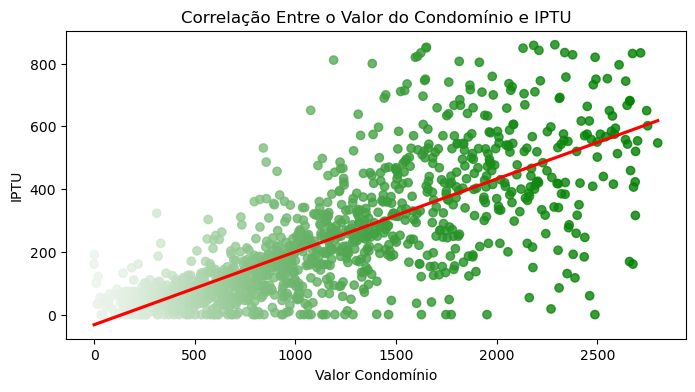

In [140]:
df = dados.select('condominio','iptu').toPandas().groupby('condominio')['iptu'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.regplot(df, x='condominio', y='iptu', ci=None, fit_reg=True, color='r',
            scatter_kws={'color': sns.color_palette('light:g', n_colors=len(df['condominio']))})
plt.title('Correlação Entre o Valor do Condomínio e IPTU')
plt.ylabel('IPTU')
plt.xlabel('Valor Condomínio')
plt.savefig('./img/graficos/condominio_iptu.png', format='png')
plt.show()

<h3>11. A Taxa de Seguro Influencia no Aluguel</h3>

A correlação positiva entre a taxa de seguro contra incêndio e o valor do aluguel é evidente no gráfico, onde ambos exibem uma tendência de aumento linear. Essa observação sugere que propriedades com aluguel mais altos tendem a ter uma taxa de seguro mais elevada. Este padrão pode ser influenciado por diversos fatores, como a valoração do imóvel, a localização e a cobertura oferecida pelo seguro, destacando a importância de considerar a variável do seguro contra incêndio ao analisar os determinantes do valor do aluguel.

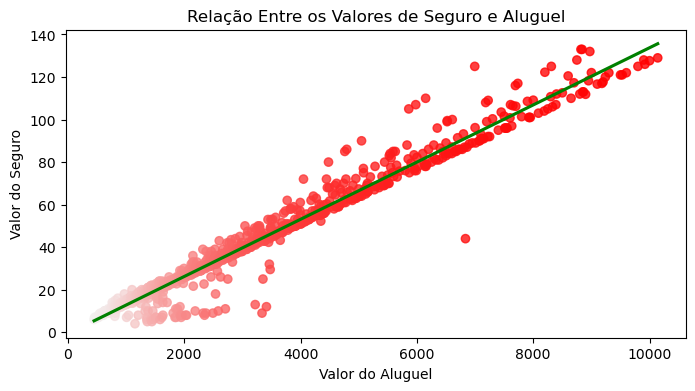

In [141]:
df = dados.select('aluguel','seguro').toPandas().groupby('aluguel')['seguro'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.regplot(df, x='aluguel', y='seguro', ci=None, fit_reg=True, color='g',
           scatter_kws={'color':sns.color_palette('light:r', n_colors=len(df['seguro']))})
plt.title('Relação Entre os Valores de Seguro e Aluguel')
plt.xlabel('Valor do Aluguel')
plt.ylabel('Valor do Seguro')
plt.savefig('./img/graficos/seguro_aluguel.png', format='png')
plt.show()

<h2>Pré-processamento dos Dados</h2>

Nesta etapa vamos realizar a padronização dos dados para que sejam compreendidos pelos algoritmos de aprendizagem de máquina que vamos, mais a frente, aplicar. O Pré-processamento será feito a partir dos seguintes passos:

- Separação das variáveis preditora e variável alvo.
- Pré-processamento dos dados das variáveis preditoras usando o [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) juntamente com o [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) e [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
- Divisão dos dados pré-processados em dados de treino e teste usando o [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- Salvando os dados já pré-processados e divididos com o [pickle](https://docs.python.org/3/library/pickle.html).

In [161]:
# Separando variáveis preditoras e variável alvo
X = dados.toPandas().drop('aluguel', axis=1)
y = dados.select('aluguel').toPandas()

<b>Pré-processamento com Pipelines</b>

In [149]:
# Definindo variáveis com features numéricas e categóricas
variavel_num = ['area','quartos','banheiros','vagas','andar','animais',
                    'mobilia','condominio','iptu','seguro','total']
variavel_cat = ['cidade']

In [150]:
# Definido transformações com estimador final
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

In [151]:
# Criando o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, variavel_num),
        ('cat', cat_transformer, variavel_cat)
    ])

In [152]:
# Aplicando o pré-processamento
X_processed = preprocessor.fit_transform(X)

In [162]:
# Dimensões da base pré-processada
print('Linhas:',X_processed.shape[0])
print('Colunas:',X_processed.shape[1])

Linhas: 8308
Colunas: 16


Após o pré-processamento dos dados, a base dos dados de variávies preditoras, apresentam um total de 8.308 linhas e 16 colunas, resultado da aplicação das transformações.

<b>Divisão dos dados em treino e teste</b>

In [158]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X_processed, y, test_size=0.25, random_state=1)

<b>Salvando dados processados</b>

In [160]:
with open('./dados/house_rent_processed.pkl', 'wb') as arquivo:
    pickle.dump([x_treino, x_teste, y_treino, y_teste], arquivo)

<h2>Modelagem Preditiva</h2>